In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/20191019_wfl647_mouse605/stacks/'

In [3]:
results = {"filename":[],
          "exp condition":[]}
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "_analyse" in str(filelist[i]):
        #if "2019" in str(filelist[i]):
            #if ("projection" in str(filelist[i]))==False:
             #   if ("zstacks" in str(filelist[i]))==True:
                #if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i]) not in str(results["filename"]):
                            results["filename"].append(filelist[i])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            
                                        

In [4]:
results["filename"]

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/20191019_wfl647_mouse605/stacks/20191019_wfl647_mouse605_Series10.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/20191019_wfl647_mouse605/stacks/20191019_wfl647_mouse605_Series11.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/20191019_wfl647_mouse605/stacks/20191019_wfl647_mouse605_Series12.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/20191019_wfl647_mouse605/stacks/20191019_wfl647_mouse605_Series13.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/20191019_wfl647_mouse605/stacks/20191019_wfl647_mouse605_Series14.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/20191019_wfl647_mouse605/stacks/20191019_wfl647_mouse605_Series10.20stacks.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201

## Loading a random image

Image name: 20191019_wfl647_mouse605_Series12.20stacks.tif


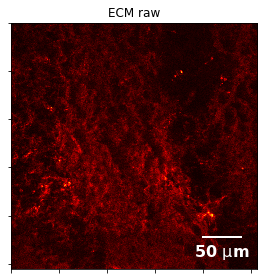

In [5]:
randomno=np.random.randint(1,len(results["filename"]))

ecm_image_name=results["filename"][randomno]

print("Image name:",results["filename"][randomno].split('/')[-1])

ecm_image=pims.open(ecm_image_name)[0]

   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(300, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)


## Write average z stacks to new folder

In [10]:
from tifffile import imsave
for file in results["filename"]:
    ecm_image_full=pims.open(file)
    stack=np.zeros([20,1024,1024],'int8')
    for i in range(0,20):
        stack[i]=ecm_image_full[i]
        

    imsave(file[:-3]+'20stacks.tif', stack)
        

TiffPages: invalid page offset (24348038)
TiffPages: invalid page offset (22230818)
TiffPages: invalid page offset (22230818)
TiffPages: invalid page offset (21172208)


In [41]:
ecm_image_full=pims.open(file)
stack=np.zeros([20,1024,1024])
for stackno in range(0,20):
    stack[i]=ecm_image_full[i]

TiffPages: invalid page offset (24348038)


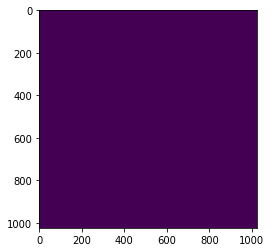

In [42]:
plt.imshow(stack[0])

In [65]:
for folder in df_results["exp condition"].unique():
    dffolder=df_results[df_results["exp condition"]==folder]
    dffolder=dffolder.reset_index()
    foldername=('/').join(dffolder["filename"][0][:-12].split('/')[:-1])
    os.mkdir(foldername+ '/maxprojections/')
    os.mkdir(foldername+ '/averageprojections/')
    for file in dffolder["filename"]:
        stack_ecm=[]
     §   stack_endosome=[]
        for stackno in range(0,7):
            ecm_image_name=file+str(stackno)+"_ch"+str(ecm_channel_no-1)+"_t0.tif"
            endosome_image_name=file+str(stackno)+"_ch"+str(endosome_channel_no-1)+"_t0.tif"
            ecm_image=pims.open(ecm_image_name)[0]
            endosome_image=pims.open(endosome_image_name)[0]
            stack_ecm.append(ecm_image)
            stack_endosome.append(endosome_image)
        max_ecm=np.array(stack_ecm).max(axis=0)
        average_ecm=np.array(stack_ecm).mean(axis=0)
        max_endosome=np.array(stack_endosome).max(axis=0)
        average_endosome=np.array(stack_endosome).mean(axis=0)
        
        scipy.misc.imsave(foldername+ '/maxprojections/'+ ecm_image_name.split('/')[-1], max_ecm)
        scipy.misc.imsave(foldername+ '/maxprojections/'+ endosome_image_name.split('/')[-1], max_endosome)
        scipy.misc.imsave(foldername+ '/averageprojections/'+ ecm_image_name.split('/')[-1], average_ecm)
        scipy.misc.imsave(foldername+ '/averageprojections/'+ endosome_image_name.split('/')[-1], average_endosome)

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ ser

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ ser